# Name : Rishabh Patil
# SAP  : 60009200056
# Batch: D12

# Introduction

In this tutorial, we will make use of the next-generation Pose Detection model from Google Research, which can detect up to 17 keypoints in the human body.

# MoveNet architecture in a nutshell

## How does it work ?

MoveNet uses heatmaps to accurately localize human keypoints. It's a **bottom-up** estimation model, which means that it first detects the human joints of all persons, and then assemble these joints into poses for each person.[[Source]](https://arxiv.org/pdf/1807.09972.pdf#:~:text=The%20top%2Ddown%20approaches%20first,full%20poses%20for%20all%20persons.)

## Architecture (2 main components)

- **Feature extractor** : A MobileNetV2 with an attached feature pyramid network. [Learn more about MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf)
- **A set of predictor heads** : attached to the feature extractor. They are responsible for predicting :
 - the geometric center of the instances (persons)
 - the full set of keypoints for a person
 - the location of all the keypoints
 - local offsets from each output feature map pixel to the precise sub-pixel location of each keypoint


## [A deeper explanation on the MoveNet processing steps](https://blog.tensorflow.org/2021/05/next-generation-pose-detection-with-movenet-and-tensorflowjs.html). Now, let's start coding !





# Libraries

In [ ]:
# Computer vision/graphics library
import cv2

# Gif writer
import imageio

# Display libraries
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Calculations and Deep Learning library
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
! pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


> We will use the "embed" module from TF Docs to embed the generated gif to our Notebook

# Setup

## Map the bones (keypoint edges) to a matplotlib color name

> ![Colors_index](https://raw.githubusercontent.com/Justsecret123/Human-pose-estimation/main/Screenshots/mpl_colors.PNG)

In [ ]:
cyan = (255, 255, 0)
magenta = (255, 0, 255)

In [ ]:
EDGE_COLORS = {
    (0, 1): magenta,
    (0, 2): cyan,
    (1, 3): magenta,
    (2, 4): cyan,
    (0, 5): magenta,
    (0, 6): cyan,
    (5, 7): magenta,
    (7, 9): cyan,
    (6, 8): magenta,
    (8, 10): cyan,
    (5, 6): magenta,
    (5, 11): cyan,
    (6, 12): magenta,
    (11, 12): cyan,
    (11, 13): magenta,
    (13, 15): cyan,
    (12, 14): magenta,
    (14, 16): cyan
}

# Load the model from TF hub

> *Notes* : MoveNet is offered with two variants, known as :
> - **Lightning :** intended for latency-critical applications
> - **Thunder :** for applications that require high accuracy

We will load the multipose *Lightning* model, which is able to detect mutliple people (up to 6 instances) in the image frame at the same time.

In [ ]:
model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures["serving_default"]

# Adjust the input size

According to [the official documentation](https://tfhub.dev/google/movenet/multipose/lightning/1) :

1. The height/width are both multiple of 32.
2. The height to width ratio is close (and enough) to cover the original image's aspect ratio.
3. Make the larger side to be 256 (one should adjust this based on the speed/accuracy requirements). For example, a 720p image (i.e. 720x1280 (HxW)) should be resized and padded to 160x256 image.

Following these rules, our input_gif would have been reshaped like this :
- width : 461 ---> 256 (the larger side = 256).
- height : 250 ---> 250 * (250/461) ~136. Since the rule 1 specifies the height to be a mutliple of 32, we'd have to round it to the closest one, which is 128.

> *Note : 250/461 is the aspect ratio.  

For visualization purposes, we'll set the input_size to 256*256.

In [ ]:
#initial_width, initial_height = (461,250)
WIDTH = HEIGHT = 256

# Inference

## Download the test gif

In [ ]:
! wget -O image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg

--2023-10-25 10:19:54--  https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.16.235.10, 104.16.234.10, 2606:4700::6810:eb0a, ...
Connecting to images.pexels.com (images.pexels.com)|104.16.235.10|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-10-25 10:19:55 ERROR 403: Forbidden.



## Define the loop

Steps : loop through the results ---> Draw the keypoints ----> Draw the edges

In [ ]:
def loop(frame, keypoints, threshold=0.11):
    """
    Main loop : Draws the keypoints and edges for each instance
    """

    # Loop through the results
    for instance in keypoints:
        # Draw the keypoints and get the denormalized coordinates
        denormalized_coordinates = draw_keypoints(frame, instance, threshold)
        # Draw the edges
        draw_edges(denormalized_coordinates, frame, EDGE_COLORS, threshold)

## Draw keypoints

### Steps :
- Get the parameters (shape): width, height, channel
- Denormalize the output coordinates by mutliplying the keypoints with the with the parameters
- Iterate through the denormalized keypoints and draw the circles where the confidence score is higher than the preset threshold

In [ ]:
def draw_keypoints(frame, keypoints, threshold=0.11):
    """Draws the keypoints on a image frame"""

    # Denormalize the coordinates : multiply the normalized coordinates by the input_size(width,height)
    denormalized_coordinates = np.squeeze(np.multiply(keypoints, [WIDTH,HEIGHT,1]))
    #Iterate through the points
    for keypoint in denormalized_coordinates:
        # Unpack the keypoint values : y, x, confidence score
        keypoint_y, keypoint_x, keypoint_confidence = keypoint
        if keypoint_confidence > threshold:
            """"
            Draw the circle
            Note : A thickness of -1 px will fill the circle shape by the specified color.
            """
            cv2.circle(
                img=frame,
                center=(int(keypoint_x), int(keypoint_y)),
                radius=4,
                color=(255,0,0),
                thickness=-1
            )
    return denormalized_coordinates

## Draw the edges
### Steps :
- Iterate through the edges and draw the edges
- Get the edge points and the associated dict value
- Draw the lines where the confidence score is higher than the preset threshold

In [ ]:
def draw_edges(denormalized_coordinates, frame, edges_colors, threshold=0.11):
    """
    Draws the edges on a image frame
    """

    # Iterate through the edges
    for edge, color in edges_colors.items():
        # Get the dict value associated to the actual edge
        p1, p2 = edge
        # Get the points
        y1, x1, confidence_1 = denormalized_coordinates[p1]
        y2, x2, confidence_2 = denormalized_coordinates[p2]
        # Draw the line from point 1 to point 2, the confidence > threshold
        if (confidence_1 > threshold) & (confidence_2 > threshold):
            cv2.line(
                img=frame,
                pt1=(int(x1), int(y1)),
                pt2=(int(x2), int(y2)),
                color=color,
                thickness=2,
                lineType=cv2.LINE_AA # Gives anti-aliased (smoothed) line which looks great for curves
            )

## Progress bar

In [ ]:
def progress(value, max=100):
    """
    Returns an HTML progress bar with a certain value. Used within each step
    """


    return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value,
                max=max))

## Capture and process each frame

### Load the gif

In [ ]:
def load_gif():
    """
    Loads the gif and return its details
    """

    # Load the gif
    gif = cv2.VideoCapture("/content/ngannou.gif")
    # Get the frame count
    frame_count = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))
    # Display parameter
    print(f"Frame count: {frame_count}")

    """""
    Initialize the video writer
    We'll append each frame and its drawing to a vector, then stack all the frames to obtain a sequence (video).
    """
    output_frames = []

    # Get the initial shape (width, height)
    initial_shape = []
    initial_shape.append(int(gif.get(cv2.CAP_PROP_FRAME_WIDTH)))
    initial_shape.append(int(gif.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    print(initial_shape)
    return gif, frame_count, output_frames, initial_shape

In [ ]:
def load_image():
  image = cv2.imread('/content/3897.11-yoga-icon-iconbunny.jpg')
  height, width, channels = image.shape
  output_frames=[]
  initial_shape=[height,width]
  print(initial_shape)
  return image,1,output_frames,initial_shape

## Run inference

In [ ]:
def run_inference():
    """
    Runs inferences then starts the main loop for each frame
    """

    # Load the gif
    gif, frame_count, output_frames, initial_shape = load_image()



    # Copy the frame
    image = gif
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # Resize to the target shape and cast to an int32 vector
    input_image = tf.cast(tf.image.resize_with_pad(image, WIDTH, HEIGHT), dtype=tf.int32)
    # Create a batch (input tensor)
    input_image = tf.expand_dims(input_image, axis=0)

    # Perform inference
    results = movenet(input_image)
    """
    Output shape :  [1, 6, 56] ---> (batch size), (instances), (xy keypoints coordinates and score from [0:50]
    and [ymin, xmin, ymax, xmax, score] for the remaining elements)
    First, let's resize it to a more convenient shape, following this logic :
    - First channel ---> each instance
    - Second channel ---> 17 keypoints for each instance
    - The 51st values of the last channel ----> the confidence score.
    Thus, the Tensor is reshaped without losing important information.
    """

    keypoints = results["output_0"].numpy()[:,:,:51].reshape((6,17,3))

    # Loop through the results
    loop(image, keypoints, threshold=0.11)

    # Get the output frame : reshape to the original size
    frame_rgb = cv2.cvtColor(
        cv2.resize(
            image,(initial_shape[0], initial_shape[1]),
            interpolation=cv2.INTER_LANCZOS4
        ),
        cv2.COLOR_BGR2RGB # OpenCV processes BGR images instead of RGB
    )

    # Add the drawings to the output frames
    output_frames.append(frame_rgb)



    print("Completed !")

    return output_frames

In [ ]:
output_frames = run_inference()

[1024, 1024]
Completed !


## Display the results

In [ ]:
from tensorflow_docs.vis import embed

For Coloured


In [ ]:
# Stack the output frames horizontally to compose a sequence
output = np.stack(output_frames, axis=0)
# Write the sequence to a gif
imageio.mimsave("./output_image.jpeg", output, fps=30)
# Embed the output to the notebook


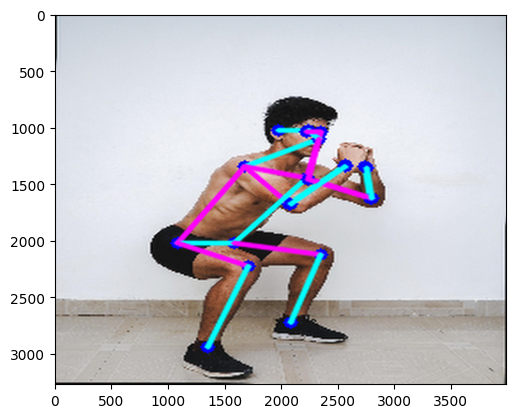

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('output_image.jpeg'))

For GrayScale

In [ ]:
# Stack the output frames horizontally to compose a sequence
output = np.stack(output_frames, axis=0)
# Write the sequence to a gif
imageio.mimsave("./output_image1.jpeg", output, fps=30)
# Embed the output to the notebook


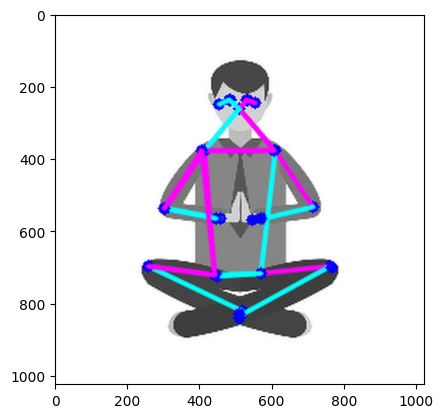

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('output_image1.jpeg'))